## Logistic Regression

### Load the Pumpkin data
Load up required libraries and dataset. Convert the data to a dataframe containing a subset of the data:
- Only get pumpkins priced by the bushel
- Calculate the price to be an average of high and low prices
- Convert the price to reflect the pricing by bushel quantity
- Categorize the retail store based on price tag

1. Prepare the data

In [78]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import re
from datetime import datetime 

# Load the data from file
pumpkins = pd.read_csv('../data/US-pumpkins.csv')
pumpkins.head()

# Select useful columns 
columns_to_use = ['Package', 'Variety', 'City Name', 'Item Size', 'Low Price', 'High Price']
pumpkins = pumpkins[pumpkins['Package'].str.contains(r"bushel|inch bins", case=True, regex=True)]
pumpkins = pumpkins.loc[:, columns_to_use]
pumpkins.dropna(inplace=True)

# Define new data array: price, store
price = (pumpkins['Low Price'] + pumpkins['High Price'])/2

# Create new dataframe
new_pumpkins = pd.DataFrame(
    {'Package': pumpkins['Package'],
    'Variety': pumpkins['Variety'],
    'City': pumpkins['City Name'],
    'Size': pumpkins['Item Size'],
    'Low Price': pumpkins['Low Price'],
    'High Price': pumpkins['High Price'],
    'Price': price}
)

# Standardize the price amount 
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9 bushel'), 'Price'] = new_pumpkins['Price']/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2 bushel'), 'Price'] = new_pumpkins['Price']*2
new_pumpkins.loc[new_pumpkins['Package'].str.contains('24 inch'), 'Price'] = new_pumpkins['Price']/5
new_pumpkins.loc[new_pumpkins['Package'].str.contains('36 inch'), 'Price'] = new_pumpkins['Price']/16.8


# Add retail store
condition = new_pumpkins['Price'] > 25.0
store = np.where(condition, 'WholeFoods', 'Walmart')
new_pumpkins['Store'] = store

# Print the data
print(new_pumpkins)

           Package            Variety       City  Size  Low Price  High Price  \
2     24 inch bins        HOWDEN TYPE  BALTIMORE   med      160.0       160.0   
3     24 inch bins        HOWDEN TYPE  BALTIMORE   med      160.0       160.0   
4     24 inch bins        HOWDEN TYPE  BALTIMORE   lge       90.0       100.0   
5     24 inch bins        HOWDEN TYPE  BALTIMORE   lge       90.0       100.0   
6     36 inch bins        HOWDEN TYPE  BALTIMORE   med      160.0       170.0   
...            ...                ...        ...   ...        ...         ...   
1698  24 inch bins  HOWDEN WHITE TYPE  ST. LOUIS  xlge      150.0       150.0   
1753  36 inch bins          MINIATURE  ST. LOUIS   sml      275.0       275.0   
1754  36 inch bins          MINIATURE  ST. LOUIS   sml      275.0       275.0   
1755  36 inch bins          MINIATURE  ST. LOUIS   sml      275.0       275.0   
1756  36 inch bins          MINIATURE  ST. LOUIS   sml      275.0       275.0   

          Price       Store

### Visualization - Categorical plot
After preparing the data, also adding new variables such as price and retail store; then visualize the dataframe.

2. Visualize the data

Text(0, 0.5, 'Variety')

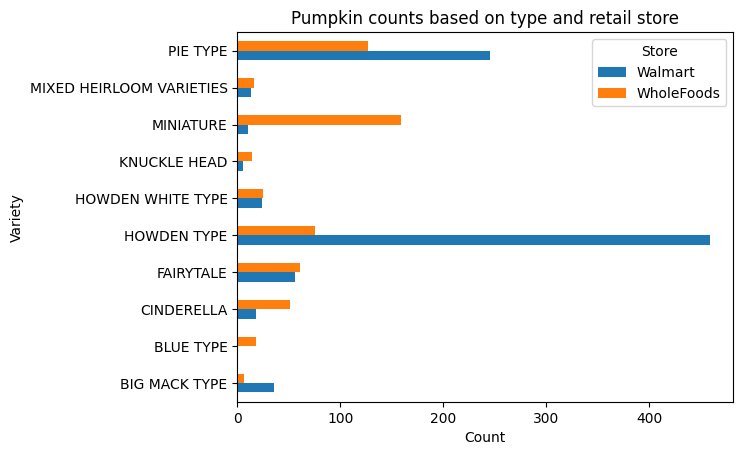

In [79]:
# Create multi-index series
store_sum = new_pumpkins.groupby('Variety')['Store'].value_counts()

# Unstack series to dataframe
store_df = store_sum.unstack()

# Plot the data in a bar chart
store_df.plot(kind='barh')
plt.title('Pumpkin counts based on type and retail store')
plt.xlabel("Count")
plt.ylabel("Variety")


### Pre-processing - Feature and Label encoding
Machine learning algorithms work well with numbers. Encoding is a very important step in data pre-processing, since it enables us to turn categorical data into numerical data without losing information.

3. Ordinal encoder

It suits well for ordinal variables, which are categorical variables where their data follows a logical ordering, like `Size` column in the dataset. It creates a mapping such that each category is represented by a number.

In [80]:
# Use ordinal encoder for ordinal variables
from sklearn.preprocessing import OrdinalEncoder

item_size_categories = [['sml', 'med', 'med-lge', 'lge', 'xlge', 'jbo', 'exjbo']]
ordinal_features = ['Size']
ordinal_encoder = OrdinalEncoder(categories=item_size_categories)

4. Categorical encode

It suits well for nominal variables, which are categorical variables where their data does not follow a logical ordering, like all the features different from `Size` in the dataset. It is a one-hot encoding, which means that each category is represented by a binary column: the encoded variable is equal to 1 if the pumpkin belongs to that Variety and 0 otherwise.

In [81]:
# Use categorical encoder for nominal variables
from sklearn.preprocessing import OneHotEncoder

categorical_features = ['City', 'Package', 'Variety']
categorical_encoder = OneHotEncoder(sparse_output=False)

5. Combine multiple encoder into one step

Use `ColumnTransformer` to combine multiple encoders into a single step and apply them to the appropriate columns.

In [82]:
# Use Column Transformer to combine them together
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer(transformers=[
('ord', ordinal_encoder, ordinal_features),
('cat', categorical_encoder, categorical_features)
])
column_transformer.set_output(transform='pandas')
encoded_features = column_transformer.fit_transform(new_pumpkins)

6. Encode the binary retail store data
Use the scikit-learn `LabelEncoder` class, which is a utility class to help normalize labels such that they contain only values 0 and 1.

In [83]:
# Encode data using Label Encoder class
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(new_pumpkins['Store'])
encoded_pumpkins = encoded_features.assign(Store=encoded_label)

### Analyze relationships between variables
Now that we have pre-processed our data, we can analyze the relationships between the features and the label to grasp an idea of how well the model will be able to predict the label given features.

The best way to perform this kind of analysis is plotting the data.

7. Plot the data

/var/folders/lx/bt6372hd2fq1t__yfh69dpyc0000gn/T/ipykernel_16691/1700857901.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


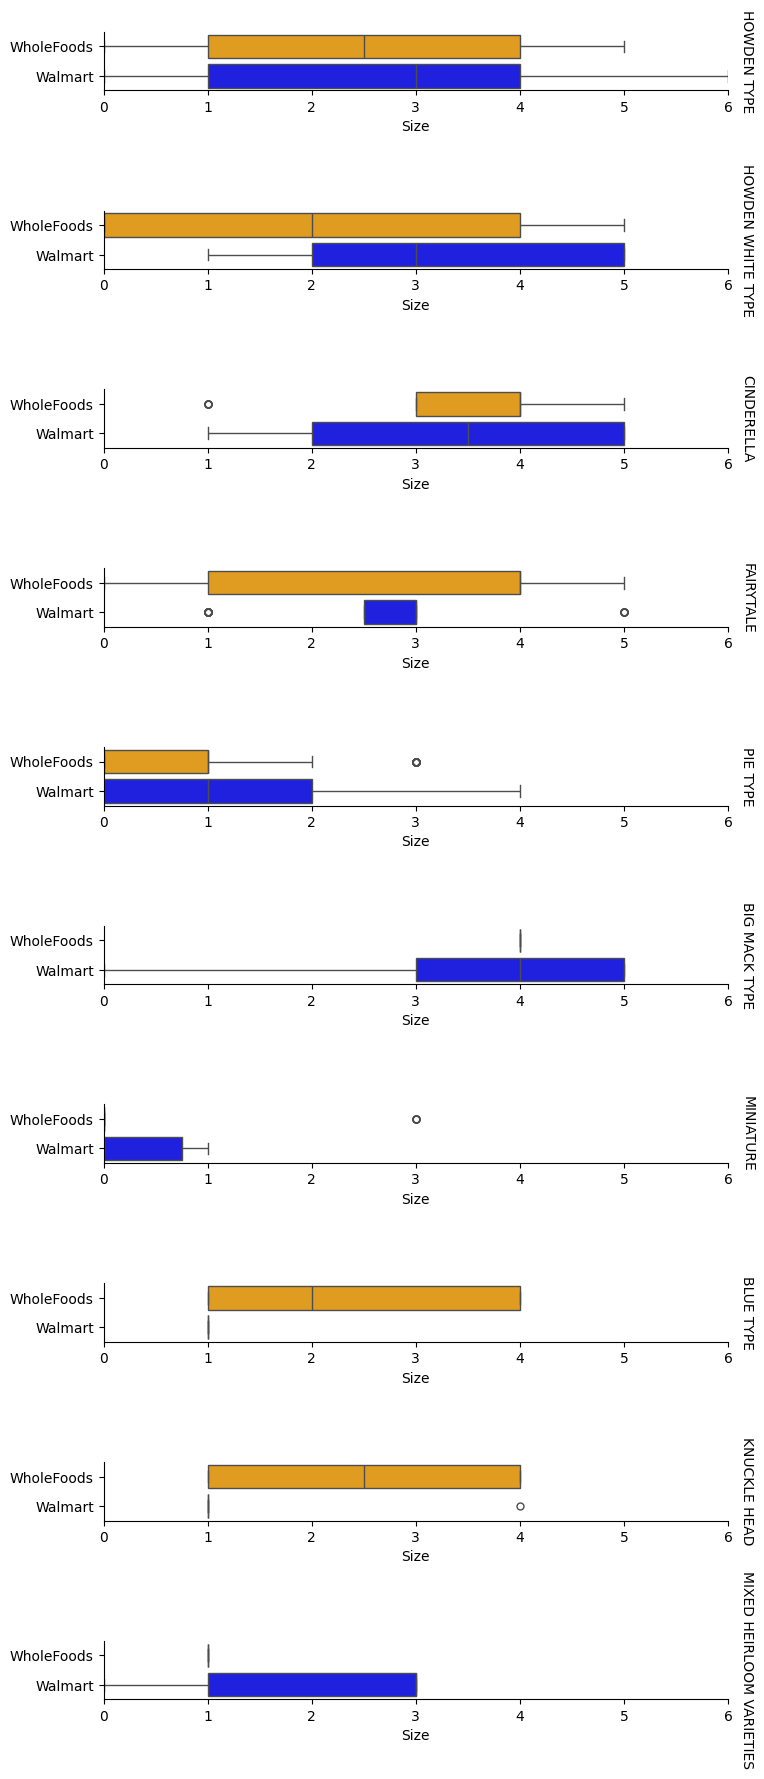

In [84]:
# Use seaborn to plot the categorical data
import seaborn as sns
palette = {
'Walmart': 'blue',
'WholeFoods': 'orange',
}
new_pumpkins['Size'] = encoded_pumpkins['ord__Size']

g = sns.catplot(
    data=new_pumpkins,
    x="Size", y="Store", row='Variety',
    kind="box", orient="h",
    sharex=False, margin_titles=True,
    height=1.8, aspect=4, palette=palette,
)
g.set(xlabel="Size", ylabel="").set(xlim=(0,6))
g.set_titles(row_template="{row_name}")

8. Use a swarm plot to show the distribution of values

/var/folders/lx/bt6372hd2fq1t__yfh69dpyc0000gn/T/ipykernel_16691/2974200750.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x='Store', y='ord__Size', data=encoded_pumpkins, palette=palette,)
/usr/local/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 64.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 52.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Axes: xlabel='Store', ylabel='ord__Size'>

/usr/local/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 80.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 70.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


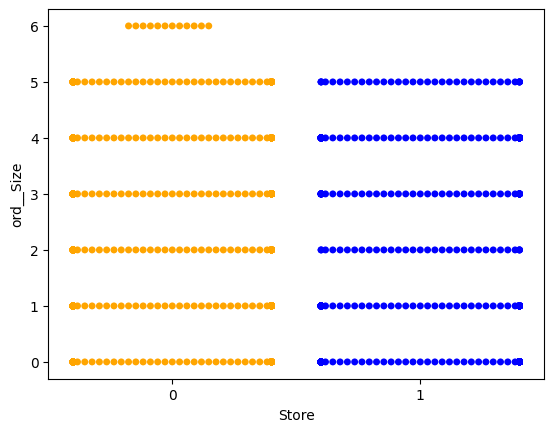

In [87]:
palette = {
'0': 'orange',
'1': 'blue',
}
sns.swarmplot(x='Store', y='ord__Size', data=encoded_pumpkins, palette=palette,)

### Build the model
Building a model to find these binary classification is surprisingly straightforward in Scikit-learn.

9. Select the variables to use in the classification model

In [88]:
# Select the dataset
from sklearn.model_selection import train_test_split

X = encoded_pumpkins[encoded_pumpkins.columns.difference(['Store'])]
Y = encoded_pumpkins['Store']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

10. Train the model using Logistic Regression

In [89]:
# Train the model
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

# Print model scoreboard
print(classification_report(Y_test, predictions))
print('F1 Score: ', f1_score(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.92      0.96       178
           1       0.88      0.99      0.93       107

    accuracy                           0.95       285
   macro avg       0.94      0.96      0.95       285
weighted avg       0.95      0.95      0.95       285

F1 Score:  0.933920704845815


11. Calculate the confusion matrix
A "confusion matrix" is a table that expresses your model's true vs. false positives and negatives, thus gauging the accuracy of predictions.

In [90]:
# Use a confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, predictions)

array([[164,  14],
       [  1, 106]])

### Visualize the ROC curve of the model
ROC (Receiving Operating Characteristic) curves are often used to get a view of the output of a classifier in terms of its true vs. false positives.

Thus, the steepness of the curve and the space between the midpoint line and the curve matter: you want a curve that quickly heads up and over the line.

12. Visualize model with ROC curve

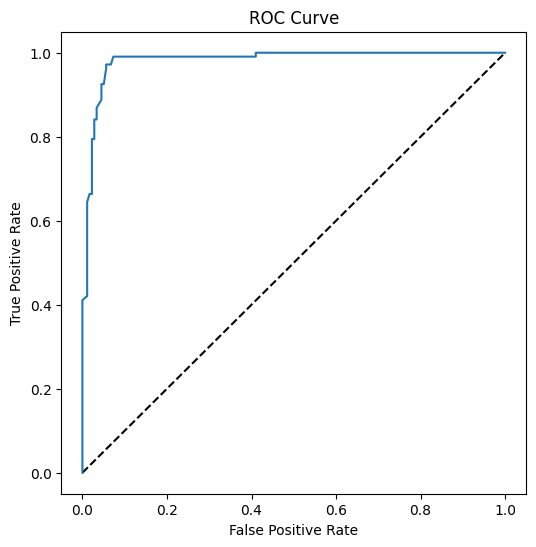

In [91]:
# Import the ROC curve library
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib

# Get the model output scores
Y_scores = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_scores[:,1])

fig = plt.figure(figsize=(6, 6))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve')
plt.show()